In [41]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [42]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [43]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   SAIA    1259 non-null   float64
 3   AXP     1259 non-null   float64
 4   TROW    1259 non-null   float64
 5   CG      1259 non-null   float64
 6   CSWC    1259 non-null   float64
 7   CBRE    1259 non-null   float64
 8   SBAC    1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  QCOM    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  DSGX    1259 non-null   float64
 13  MGIC    1259 non-null   float64
 14  RDWR    1259 non-null   float64
 15  CTLT    1259 non-null   float64
 16  BRKR    1259 non-null   float64
 17  ICLR    1259 non-null   float64
 18  MODV    1259 non-null   float64
 19  ^FVX    1259 non-null   float64
dtypes: float64(20)
memory usage: 206.6 KB


## Function that saves dataframe to CSV

In [44]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [45]:
# for ticker in tickers:
#     panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
# #     close = panel_data['Close']
#     adj_close = panel_data['Close']
#     save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [46]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [47]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [48]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [49]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
    
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [50]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [51]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [52]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [53]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV']

#add in the weightage of stocks
port_shares = [0.0145161,0.068463,0.0070209,0.00164655,0.01234755,0.0179883,0.0130176,0.033096,
               0.071904,0.0091785,2.43E-05,0.0103785,0.0060897,0.0027567,0.0015723,0.0087756,
               0.0066555,0.0100752,0.0044937]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.491094,3.960813,0.315238,0.124068,0.936438,0.280617,0.212708,1.044841,7.588029,0.584303,...,1.146305,0.129406,0.019021,0.023081,0.236941,0.143626,0.752718,0.172423,19.163260,NaN
2017-01-04,1.499223,3.977244,0.316292,0.125566,0.950391,0.288712,0.217915,1.061720,7.598815,0.590728,...,1.140805,0.130624,0.019159,0.023207,0.239662,0.145090,0.773977,0.176962,19.277681,0.005971
2017-01-05,1.501110,3.930233,0.308569,0.124018,0.942982,0.293209,0.217654,1.052784,7.498149,0.594308,...,1.154504,0.128797,0.019297,0.023097,0.236064,0.145423,0.767831,0.176153,19.115774,-0.008399
2017-01-06,1.517658,3.929776,0.315098,0.124265,0.933722,0.299505,0.214790,1.032595,7.443502,0.613766,...,1.153259,0.129406,0.019159,0.023034,0.235888,0.146687,0.792414,0.177276,19.103395,-0.000648
2017-01-09,1.482674,3.908324,0.309622,0.124907,0.899272,0.300405,0.217654,1.030278,7.405393,0.613491,...,1.167477,0.129102,0.019159,0.022798,0.236151,0.148285,0.809744,0.175973,19.002306,-0.005292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.053171,24.345443,2.338311,0.270676,2.461114,1.010043,0.326612,3.567418,27.565116,6.397414,...,8.421426,0.498259,0.059021,0.064181,1.108885,0.550809,3.099333,0.678998,85.820759,0.021672
2021-12-28,3.079736,24.416645,2.318231,0.270709,2.462225,0.997811,0.325831,3.565101,27.663627,6.261573,...,8.352306,0.499355,0.058084,0.063568,1.100109,0.546283,3.083515,0.673965,85.743165,-0.000904
2021-12-29,3.082784,24.702135,2.354880,0.269754,2.439135,0.978024,0.324138,3.593564,27.679446,6.221555,...,8.323349,0.502035,0.058194,0.065203,1.123979,0.557198,3.103061,0.675044,86.058002,0.003672


## Get old data for portfolio

In [54]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.491094,3.960813,0.315238,0.124068,0.936438,0.280617,0.212708,1.044841,7.588029,0.584303,...,1.146305,0.129406,0.019021,0.023081,0.236941,0.143626,0.752718,0.172423,19.163260,NaN
2017-01-04,1.499223,3.977244,0.316292,0.125566,0.950391,0.288712,0.217915,1.061720,7.598815,0.590728,...,1.140805,0.130624,0.019159,0.023207,0.239662,0.145090,0.773977,0.176962,19.277681,0.005971
2017-01-05,1.501110,3.930233,0.308569,0.124018,0.942982,0.293209,0.217654,1.052784,7.498149,0.594308,...,1.154504,0.128797,0.019297,0.023097,0.236064,0.145423,0.767831,0.176153,19.115774,-0.008399
2017-01-06,1.517658,3.929776,0.315098,0.124265,0.933722,0.299505,0.214790,1.032595,7.443502,0.613766,...,1.153259,0.129406,0.019159,0.023034,0.235888,0.146687,0.792414,0.177276,19.103395,-0.000648
2017-01-09,1.482674,3.908324,0.309622,0.124907,0.899272,0.300405,0.217654,1.030278,7.405393,0.613491,...,1.167477,0.129102,0.019159,0.022798,0.236151,0.148285,0.809744,0.175973,19.002306,-0.005292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.053171,24.345443,2.338311,0.270676,2.461114,1.010043,0.326612,3.567418,27.565116,6.397414,...,8.421426,0.498259,0.059021,0.064181,1.108885,0.550809,3.099333,0.678998,85.820759,0.021672
2021-12-28,3.079736,24.416645,2.318231,0.270709,2.462225,0.997811,0.325831,3.565101,27.663627,6.261573,...,8.352306,0.499355,0.058084,0.063568,1.100109,0.546283,3.083515,0.673965,85.743165,-0.000904
2021-12-29,3.082784,24.702135,2.354880,0.269754,2.439135,0.978024,0.324138,3.593564,27.679446,6.221555,...,8.323349,0.502035,0.058194,0.065203,1.123979,0.557198,3.103061,0.675044,86.058002,0.003672


## Forecasting

In [55]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [56]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [57]:
tot_port_df

,LHX,ODFL,SAIA,AXP,TROW,CG,CSWC,CBRE,SBAC,EPAM,...,ASML,DSGX,MGIC,RDWR,CTLT,BRKR,ICLR,MODV,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,1.491094,3.960813,0.315238,0.124068,0.936438,0.280617,0.212708,1.044841,7.588029,0.584303,...,1.146305,0.129406,0.019021,0.023081,0.236941,0.143626,0.752718,0.172423,19.163260,NaN
2017-01-04,1.499223,3.977244,0.316292,0.125566,0.950391,0.288712,0.217915,1.061720,7.598815,0.590728,...,1.140805,0.130624,0.019159,0.023207,0.239662,0.145090,0.773977,0.176962,19.277681,0.005971
2017-01-05,1.501110,3.930233,0.308569,0.124018,0.942982,0.293209,0.217654,1.052784,7.498149,0.594308,...,1.154504,0.128797,0.019297,0.023097,0.236064,0.145423,0.767831,0.176153,19.115774,-0.008399
2017-01-06,1.517658,3.929776,0.315098,0.124265,0.933722,0.299505,0.214790,1.032595,7.443502,0.613766,...,1.153259,0.129406,0.019159,0.023034,0.235888,0.146687,0.792414,0.177276,19.103395,-0.000648
2017-01-07,1.517658,3.929776,0.315098,0.124265,0.933722,0.299505,0.214790,1.032595,7.443502,0.613766,...,1.153259,0.129406,0.019159,0.023034,0.235888,0.146687,0.792414,0.177276,19.103395,-0.000648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,3.053171,24.345443,2.338311,0.270676,2.461114,1.010043,0.326612,3.567418,27.565116,6.397414,...,8.421426,0.498259,0.059021,0.064181,1.108885,0.550809,3.099333,0.678998,85.820759,0.021672
2021-12-28,3.079736,24.416645,2.318231,0.270709,2.462225,0.997811,0.325831,3.565101,27.663627,6.261573,...,8.352306,0.499355,0.058084,0.063568,1.100109,0.546283,3.083515,0.673965,85.743165,-0.000904
2021-12-29,3.082784,24.702135,2.354880,0.269754,2.439135,0.978024,0.324138,3.593564,27.679446,6.221555,...,8.323349,0.502035,0.058194,0.065203,1.123979,0.557198,3.103061,0.675044,86.058002,0.003672


In [58]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','SAIA','AXP','TROW','CG','CSWC','CBRE','SBAC','EPAM','QCOM','ASML','DSGX',
          'MGIC','RDWR','CTLT','BRKR','ICLR','MODV', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [59]:
tot_port_df

,Total
Date,
2017-01-03,19.163260
2017-01-04,19.277681
2017-01-05,19.115774
2017-01-06,19.103395
2017-01-07,19.103395
...,...
2021-12-27,85.820759
2021-12-28,85.743165
2021-12-29,86.058002


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1824


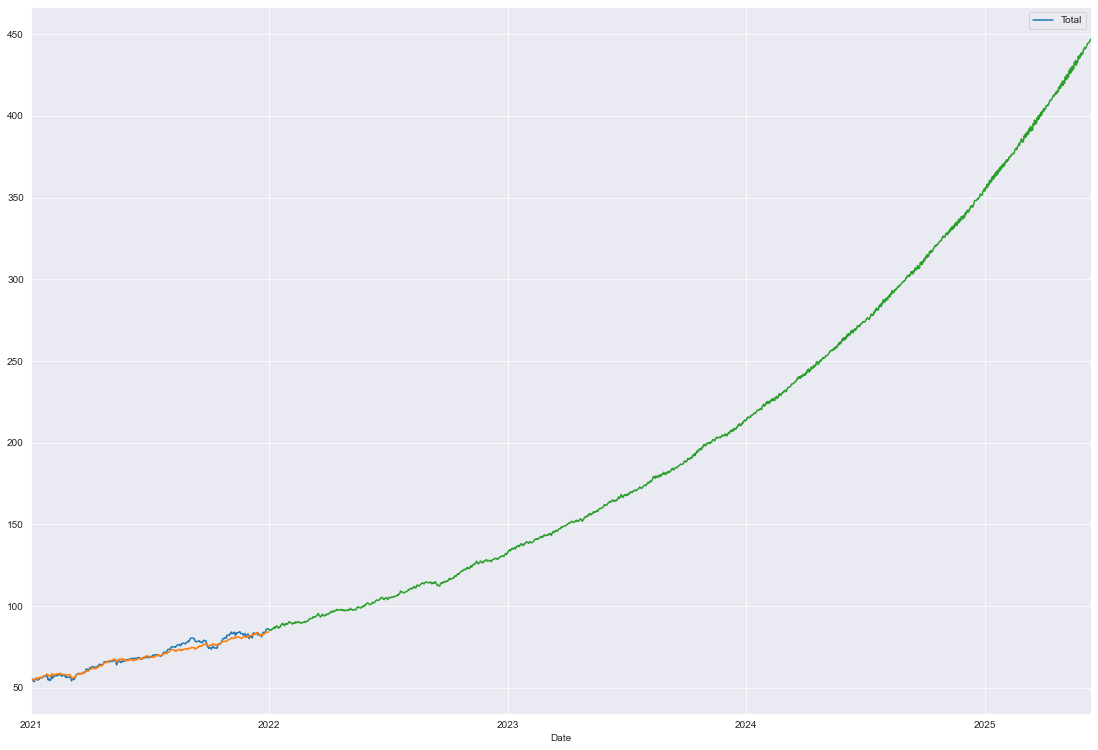

In [75]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [76]:
forecast

2021-12-31     85.649972
2022-01-01     85.522337
2022-01-02     85.027377
2022-01-03     85.032568
2022-01-04     85.462939
                 ...    
2025-06-09    444.639836
2025-06-10    445.290787
2025-06-11    445.753100
2025-06-12    446.851008
2025-06-13    446.051335
Freq: D, Length: 1261, dtype: float64

In [77]:
forecast_df = pd.DataFrame(forecast)

In [78]:
forecast_df

,0
2021-12-31,85.649972
2022-01-01,85.522337
2022-01-02,85.027377
2022-01-03,85.032568
2022-01-04,85.462939
...,...
2025-06-09,444.639836
2025-06-10,445.290787
2025-06-11,445.753100
2025-06-12,446.851008


In [79]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [80]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.001490
2022-01-02,-0.007269
2022-01-03,-0.007208
2022-01-04,-0.002184
...,...
2025-06-09,4.191360
2025-06-10,4.198960
2025-06-11,4.204358
2025-06-12,4.217176


In [81]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

6.5376224380913115